In [ ]:
import numpy as np
import scipy
import xgboost
from xgboost import XGBRegressor
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
#from sympy import Symbol, nsolve, solve
#from sympy.solvers import solve

import time
import pickle
import keras# check scikit-learn version

# check scikit-learn version
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestRegressor

from skimage.metrics import structural_similarity as ssim

In [ ]:
from tensorflow import keras
#from tensorflow.python.keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D,Cropping2D, AveragePooling2D,Dense,Flatten,Reshape,Dropout,TimeDistributed,LSTM,LeakyReLU,RepeatVector

from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D,Cropping2D,TimeDistributed, AveragePooling2D,Dense,Flatten,Reshape,Dropout,LSTM,LeakyReLU,RepeatVector,Conv2DTranspose
from tensorflow.keras.models import Model,Sequential


import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
#import seaborn_image as isns
import numpy as np
#from matplotlib import cm
#from matplotlib import animation as animation
from PIL import Image

import tensorflow as tf
from tensorflow import keras
#import keras
import time

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
field_data_u = np.load('drive/MyDrive/SW_contrastive/data/frame_data_200_u.npy')
field_data_v = np.load('drive/MyDrive/SW_contrastive/data/frame_data_200_v.npy')
field_data_h = np.load('drive/MyDrive/SW_contrastive/data/frame_data_200_h.npy')

field_data = np.zeros((20000,64,64,3))

field_data[:,:,:,0] = field_data_u
field_data[:,:,:,1] = field_data_v
field_data[:,:,:,2] = field_data_h

del field_data_u,field_data_v,field_data_h

In [ ]:
method = 'CAE'

parameter_input = np.load('drive/MyDrive/SW_contrastive/data/parameter_data_uvh_200.npy')[:20000,:]
#latent_output = np.load('drive/MyDrive/SW_contrastive/data/latent_code_64_'+method+'_200_uvh_noisy.npy')
latent_output = np.load('drive/MyDrive/SW_contrastive/data/latent_code_64_'+method+'_200_uvh.npy')

In [ ]:
field_data = field_data.reshape(1000,20,64,64,3)

In [ ]:
latent_output = latent_output.reshape(1000,20,30)

In [ ]:
latent_output.shape

(1000, 20, 30)

In [ ]:
train_input = np.zeros((7500,30))
train_output = np.zeros((7500,30))

train_index = 0
for i in range(750):
  for iter in range(10):
    train_input[train_index,:] = latent_output[i,iter,:]
    train_output[train_index,:] = latent_output[i,iter+10,:]
    train_index += 1




In [ ]:
test_input = np.zeros((2500,30))
test_output = np.zeros((2500,30))
test_out_field = np.zeros((2500,64,64,3))

test_list = []

test_index = 0
for i in range(750,1000):
  for iter in range(10):
    test_input[test_index,:] = latent_output[i,iter,:]
    test_output[test_index,:] = latent_output[i,iter+10,:]
    test_out_field[test_index,:,:,:] = field_data[i,iter+10,:,:,:]
    test_list.append([i,iter+10])
    test_index += 1

In [ ]:
test_out_field.shape

(2500, 64, 64, 3)

In [ ]:
GB_model = XGBRegressor()

GB_model.fit(train_input, train_output)

test_prediction = GB_model.predict(test_input)

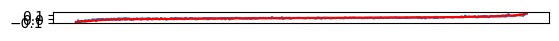

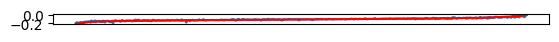

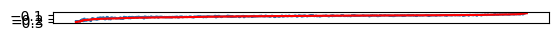

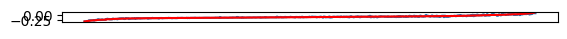

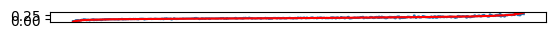

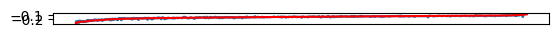

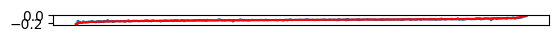

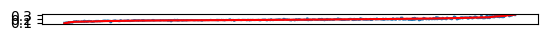

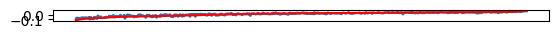

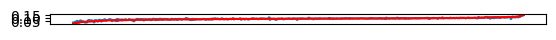

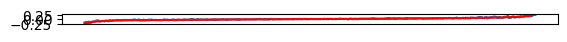

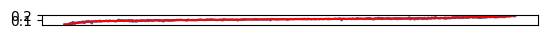

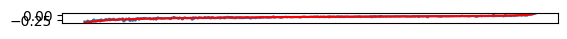

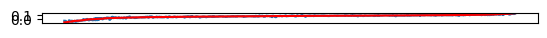

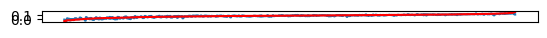

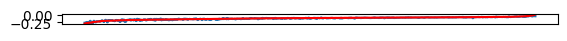

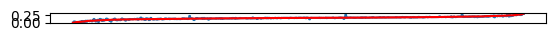

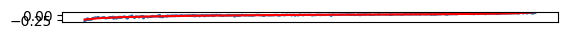

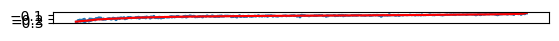

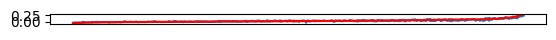

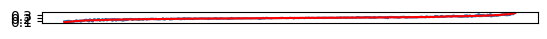

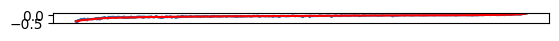

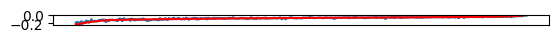

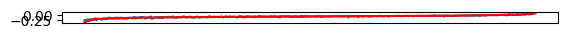

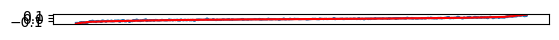

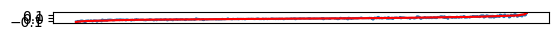

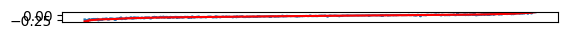

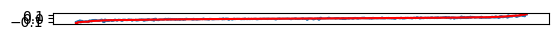

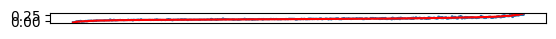

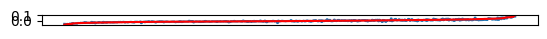

In [ ]:
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score

#plt.figure(figsize=(14,6))
for index in range(30):
  plt.subplot(30, 1, index+1)
  s = list(test_output[:,index])

  deg1 = test_output[:,index][sorted(range(len(s)), key=lambda k: s[k])]

  deg2 = test_prediction[:,index][sorted(range(len(s)), key=lambda k: s[k])]

  #print('R2',r2_score(deg1,deg2))

  plt.plot(deg2,label = "model")
  plt.plot(deg1,'r',label = "true")
  #plt.legend()
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
  plt.show()

# load encoder decoder

In [ ]:
if method == 'CAE':

  encoder = keras.models.load_model('drive/MyDrive/SW_contrastive/model/encoder_64_CAE_200_uvh.h5')
  decoder = keras.models.load_model('drive/MyDrive/SW_contrastive/model/decoder_64_CAE_200_uvh.h5')

if method == 'contrastive':
  encoder = keras.models.load_model('drive/MyDrive/SW_contrastive/model/encoder_64_contrastive_200_uvh.h5')
  decoder = keras.models.load_model('drive/MyDrive/SW_contrastive/model/decoder_64_contrastive_200_uvh.h5')

In [ ]:
field_prediction = decoder.predict(test_prediction.reshape(-1, 30,1))
field_test = decoder.predict(test_output.reshape(-1, 30,1))

79/79 [==============================] - 10s 128ms/step


In [ ]:
if method =='CAE':
  relative_error = np.linalg.norm(field_prediction[:,:,:]-test_out_field[:,:,:])/np.linalg.norm(test_out_field[:,:,:])

  ssim_list = []

  for i in range(1000):
    ssim_list.append(ssim(test_out_field[i,:,:,0], field_prediction[i,:,:,0]))

  mean_SSIM = (np.mean(np.array(ssim_list)))

  print('relative_error',relative_error)

  print('mean_SSIM',mean_SSIM)

relative_error 0.04684156667964681
mean_SSIM 0.7934973575039608


In [ ]:
if method =='contrastive':
  relative_error = np.linalg.norm(field_prediction[:,:,:]-test_out_field[:,:,:])/np.linalg.norm(test_out_field[:,:,:])

  ssim_list = []

  for i in range(1000):
    ssim_list.append(ssim(test_out_field[i,:,:,0], field_prediction[i,:,:,0]))

  mean_SSIM = (np.mean(np.array(ssim_list)))

  print('relative_error',relative_error)

  print('mean_SSIM',mean_SSIM)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


relative_error 0.04672195174552929
mean_SSIM 0.8043496106098358


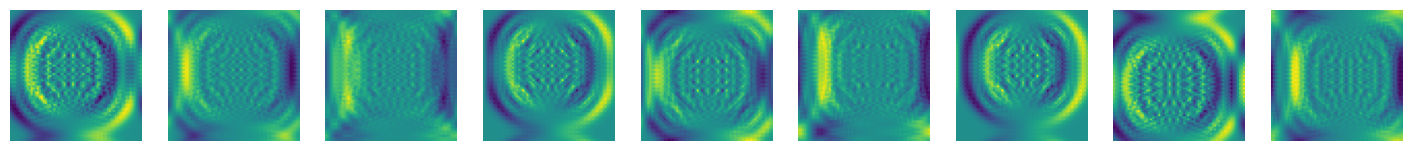

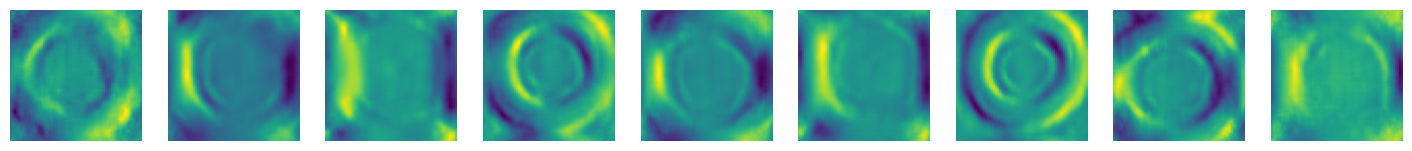

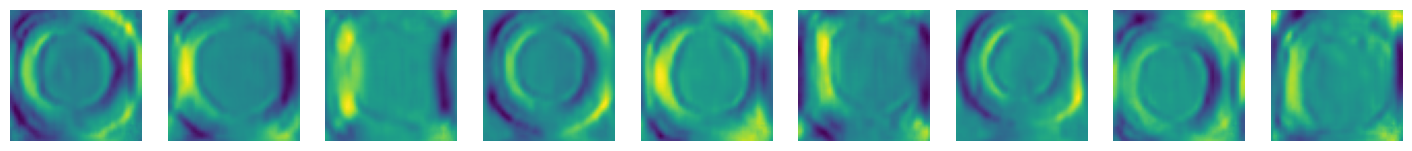

In [ ]:
if method =='contrastive':

  from matplotlib.pyplot import figure

  plt.figure(figsize=(20,9))

  for i in range(1,10):
    a = test_list[49+i*183][0]
    b = test_list[49+i*183][1]
    plt.subplot(1, 10, i)
    plt.imshow(field_data[a,b,:,:,0])
    plt.axis('off')

  plt.figure(figsize=(20,9))
  for i in range(1,10):
    plt.subplot(1, 10, i)
    plt.imshow(field_prediction_CAE[49+i*183,:,:,0])
    plt.axis('off')

  plt.figure(figsize=(20,9))
  for i in range(1,10):
    plt.subplot(1, 10, i)
    plt.imshow(field_prediction[49+i*183,:,:,0])
    plt.axis('off')


In [ ]:
field_prediction_CAE = field_prediction

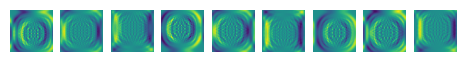

In [ ]:
  for i in range(1,10):
    a = test_list[49+i*43][0]
    b = test_list[49+i*43][1]
    plt.subplot(1, 10, i)
    plt.imshow(field_data[a,b,:,:,0])
    plt.axis('off')